# Постановка задачи
$$\underset{\| x \|^2 = 1}{min} f(x) = x^T A x + b^T x$$

# Применяется метод наискорейшего спуска
$$x^{k+1} =P_S(x^k - \gamma^k \nabla f(x^k))$$
$$\gamma^k = \underset{\gamma \geq 0}{argmin} f(P_S(x^k - \gamma \nabla f(x^k)))$$

# Вычислим шаг 
$$\underset{\gamma \geq 0}{argmin} \left(\frac{x^k - \gamma(Ax^x + b)^T}{\| x^k - \gamma(Ax^x + b) \|}\right) A \left(\frac{x^k - \gamma(Ax^x + b)}{\| x^k - \gamma(Ax^x + b) \|}\right) + b^T \left(\frac{x^k - \gamma(Ax^x + b)}{\| x^k - \gamma(Ax^x + b) \|}\right)$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
A = np.array([[1., 1., 1.], [1., -100., 1.], [1., 1., 1.]])
b = np.array([1., 2., 3.])
print A
print b
r = 1.

[[   1.    1.    1.]
 [   1. -100.    1.]
 [   1.    1.    1.]]
[ 1.  2.  3.]


# Применим метод штрафных функций:
$$M = \left(\frac{x^k - \gamma(Ax^k + b)^T}{\| x^k - \gamma(Ax^k + b) \|}\right) A \left(\frac{x^k - \gamma(Ax^k + b)}{\| x^k - \gamma(Ax^k + b) \|}\right) + b^T \left(\frac{x^k - \gamma(Ax^k + b)}{\| x^k - \gamma(Ax^k + b) \|}\right) + r (-\gamma)^2_+$$


In [3]:
def M(gamma):
    return (xk - gamma * (np.dot(A, xk) + b)).dot(np.dot(A, xk - gamma * (np.dot(A, xk) + b))) / np.linalg.norm(xk - gamma * (np.dot(A, xk) + b)) ** 2 + b.dot((xk - gamma * (np.dot(A, xk) + b))) / np.linalg.norm(xk - gamma * (np.dot(A, xk) + b)) + r * np.max([0., -gamma]) ** 2
    

## Минимум оштрафованной функции будем находить градиентным спуском. Градиент:

$$M'_{\gamma} = \frac{\gamma^2 (-2a_2'a_3 + 2a_2 a_3') + \gamma (2a_3a_1' - 2 a_2a_1' - 2a_3' a_1) + 2a_1a_2'}{(\gamma^2 a_3' - 2 \gamma a_2' + a_1' )^2} - 2b^Tx^k \frac{\sum_{i=1}^{n}(x^k_i - \gamma(Ax^k + b)_i)(Ax^k + b)_i}{\| x^k - \gamma(Ax^k + b) \|^3} - \frac{b^T (Ax^k+b)}{\| x^k - \gamma(Ax^k + b) \|}  + \gamma(Ax^k+b)^Tb \frac{\sum_{i=1}^{n}(x^k_i - \gamma(Ax^k + b)_i)(Ax^k + b)_i}{\| x^k - \gamma(Ax^k + b) \|^3} - 2r(-\gamma)_+$$
Где введены обозначения:

$a_3 = (Ax^k + b)^T A (Ax^k + b)$

$a_2 = (x^k)^TA(Ax^k + b)$

$a_1 = (x^k)^T A x^k$

$a_3' = (Ax^k + b)^T  (Ax^k + b)$

$a_2' = (x^k)^T(Ax^k + b)$

$a_1' = (x^k)^T  x^k$


In [4]:
def gradM(gamma):
    """
    a3 = (np.dot(A, xk) + b).dot(np.dot(A, np.dot(A, xk) + b))
    a2 = (xk).dot(np.dot(A, np.dot(A, xk) + b))
    a1 = (xk).dot(np.dot(A,xk))
    a3t = (np.dot(A, xk) + b).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
    a2t = (xk).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
    a1t = (xk).dot(np.dot(np.eye(A.shape[0]),xk))
    """
    first = (gamma ** 2 *(-2 * a2t * a3 + 2 * a2 * a3t) + gamma * (2 * a3 * a1t - 2 * a2 * a1t - 2 * a3t * a1) + 2 * a1 * a2t) / ((gamma ** 2 * a3t - 2 * gamma * a2t + a1t)**2)
    sumfrac = sum((xk - gamma * (np.dot(A, xk) + b)) * (np.dot(A, xk) + b)) / (np.linalg.norm(xk - gamma * (np.dot(A, xk) + b)) ** 3)
    second  = - 2 * np.dot(b, xk) * sumfrac
    third = - (np.dot(b, np.dot(A, xk) + b)) / (np.linalg.norm(xk - gamma * (np.dot(A, xk ) + b)))
    fourth =  gamma * np.dot(np.dot(A, xk) + b,b) * sumfrac
    fifth = - 2 * r * max([0., -gamma])
    return first + second + third + fourth + fifth

# Поскольку вычисление шага как в методе наискорешего спуска немного затруднительно, а константа Липшица для градиента не видна, применим для вычисления шага backtracking line search:

In [5]:
def backtracking_line_search(f, gradf, x, p): # attention! this is for scalar function of one varianle
    alpha = 1.
    c = 1e-3
    ro = 0.5
    i = 0
    while(f(x + alpha * p) < (f(x) +  c * alpha * gradf(x) * p)):
        alpha = ro * alpha
        #print 'iteration number: ', i
        #print 'alpha_i = ', alpha
        i += 1
    return alpha

In [6]:
def get_new_gamma(f, gradf, x0):
    #Pts_x = [x0]
    #Pts_y = [f(x0)]
    p = lambda x: -gradf(x)
    x1 = x0
    x2 = x1 + 1 * backtracking_line_search(f, gradf, x1, p(x1)) * p(x1)
    j = 0
    while (np.abs(x2 - x1) > 1e-1):
        x1 = x2
        x2 = x1 + backtracking_line_search(f, gradf, x1, p(x1)) * p(x1)
        #Pts_x.append(x2)
        #Pts_y.append(f(x2))
        j += 1
    #print 'total iterations: ', j
    return x2#, Pts_x, Pts_y

In [7]:
#test cell
xk = np.array([3., 10., 0])
a3 = (np.dot(A, xk) + b).dot(np.dot(A, np.dot(A, xk) + b))
a2 = (xk).dot(np.dot(A, np.dot(A, xk) + b))
a1 = (xk).dot(np.dot(A,xk))
a3t = (np.dot(A, xk) + b).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
a2t = (xk).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
a1t = (xk).dot(np.dot(np.eye(A.shape[0]),xk))
print get_new_gamma(M, gradM, 528.)

527.992661978


In [8]:
print M(1305)
print M(528)

-98.0764839072
-98.0764830411


In [31]:
print_rate = 1
k = 0
x0 = np.array([1., 0., -1.])
x0 = x0 / np.linalg.norm(x0)
notenough = True
xs = []
fs = []
xk = x0
gamma0 = 1.
while(notenough):
    a3 = (np.dot(A, xk) + b).dot(np.dot(A, np.dot(A, xk) + b))
    a2 = (xk).dot(np.dot(A, np.dot(A, xk) + b))
    a1 = (xk).dot(np.dot(A,xk))
    a3t = (np.dot(A, xk) + b).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
    a2t = (xk).dot(np.dot(np.eye(A.shape[0]), np.dot(A, xk) + b))
    a1t = (xk).dot(np.dot(np.eye(A.shape[0]),xk))
    gamma = get_new_gamma(M, gradM, gamma0)
    gamma0 = gamma
    xkk = (xk - gamma * (np.dot(A, xk) + b)) / np.linalg.norm(xk - gamma * (np.dot(A, xk) + b))
    if (np.linalg.norm(xkk - xk) < 1e-4):
        notenough = False
    k += 1
    if (k % print_rate == 0):
        print 'iter_num = ', k
        print 'xk = ', xk
        print 'xkk = ', xkk
        print 'gamma  = ', gamma
    xk = xkk
    xs.append(xkk) 
    fs.append(xkk.dot(np.dot(A, xkk)) + np.dot(b, xkk))
    if k > 20: break
print xkk

iter_num =  1
xk =  [ 0.70710678  0.         -0.70710678]
xkk =  [-0.06936698 -0.47366738 -0.87796778]
gamma  =  1.0
iter_num =  2
xk =  [-0.06936698 -0.47366738 -0.87796778]
xkk =  [ 0.00718267 -0.998714   -0.05018719]
gamma  =  1.0
iter_num =  3
xk =  [ 0.00718267 -0.998714   -0.05018719]
xkk =  [  4.11228963e-04  -9.99814906e-01  -1.92349988e-02]
gamma  =  41.2875511461
iter_num =  4
xk =  [  4.11228963e-04  -9.99814906e-01  -1.92349988e-02]
xkk =  [  1.82818629e-04  -9.99811232e-01  -1.94285094e-02]
gamma  =  41.3872170564
iter_num =  5
xk =  [  1.82818629e-04  -9.99811232e-01  -1.94285094e-02]
xkk =  [  1.86866207e-04  -9.99811307e-01  -1.94246068e-02]
gamma  =  41.4866422417
[  1.86866207e-04  -9.99811307e-01  -1.94246068e-02]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


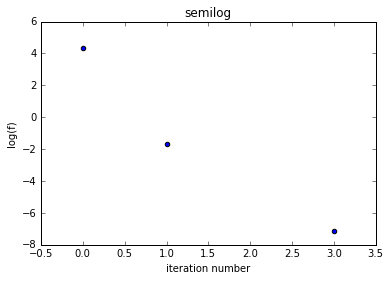

In [32]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [34]:
#xk = np.array([  5.86293514e-04,   9.99803278e-01,  -1.98257615e-02])
print xkk
print xkk.dot(np.dot(A, xkk)) + np.dot(b, xkk)
z = -xkk
print z.dot(np.dot(A, z)) + np.dot(b, z)

[  1.86866207e-04  -9.99811307e-01  -1.94246068e-02]
-101.98113623
-97.8657170929
